# Brief analysis of the data

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
import ast
import requests
import os
import statsmodels.formula.api as smf


## Importing data

In [67]:
# Import movies dataset
movie_metadata = pd.read_csv('dataset/MovieSummaries/movie.metadata.tsv', sep='\t', header=None , 
names=['WikiID', 'FreebaseID', 'Name', 'Release', 'BoxRevenue', 'Runtime', 'Languages', 'Countries', 'Genres'])
movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [68]:
# Preprocessing dataset: convert dates to datetime, countries, Genres and languages to string

movie_metadata["Release"] = movie_metadata["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)
movie_metadata["Countries"] = movie_metadata["Countries"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Languages"] = movie_metadata["Languages"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Genres"] = movie_metadata["Genres"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)

# Drop all the na values in the columns Release, Countries, Genres
movie_metadata = movie_metadata.dropna(subset=["Release", "Countries", "Genres"])

movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama]


The following characteristics can be observed in the imported data set

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


## Primary analysis

This is an initial analysis of the dataset.

**Movies country of origin**

We looked at movies' countries of origin. While doing so, we observed that most of the given movies come from the United States of America. This is a piece of important information for future analysis.
In fact, when studying characters' representation, we will know that it mostly comes from characters in US movies. It would be significant to analyze sex and ethnicity representation for each country individually.
Moreover, we looked at the time evolution of countries of origin. This analysis showed an increase in movies from the US  and United Kingdom. This time evolution could be compared to the representation evolution.



Countries
United States of America    33197
India                        7764
United Kingdom               7452
France                       4199
Italy                        3017
Japan                        2405
Canada                       2372
Germany                      2306
Argentina                    1418
Hong Kong                    1115
Name: Name, dtype: int64


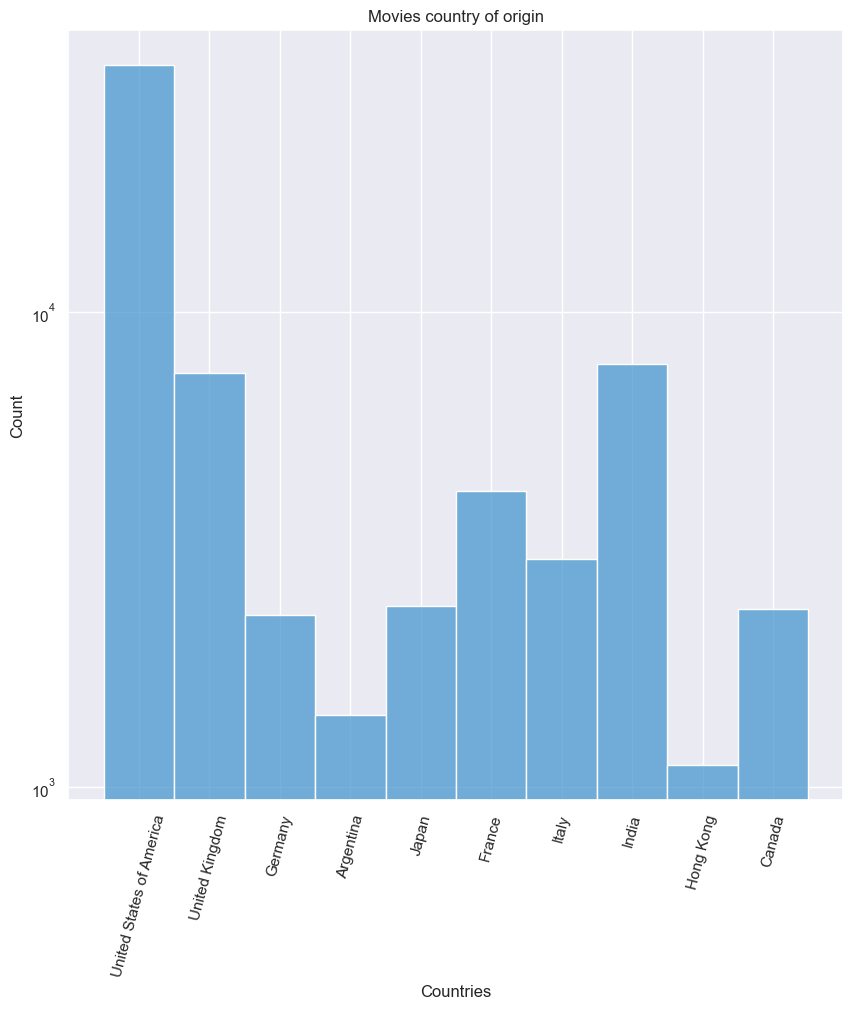

In [69]:
# Plot histogram of the countries with the most productions
tmp = movie_metadata.explode(column="Countries").reset_index(drop = True)
top = tmp.groupby(by="Countries")["Name"].count().nlargest(10).index
top_val = tmp.groupby(by="Countries")["Name"].count().nlargest(10)
sns.histplot(data=tmp[tmp["Countries"].isin(top)], x="Countries",log_scale=(False,True))
plt.xticks(rotation=75)
plt.title('Movies country of origin')
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("darkgrid")
# Filter the  top producing countries
processed = movie_metadata[movie_metadata["Countries"].apply(lambda x: any(e in top[0:5] for e in x))].reset_index()
processed.head()
print(top_val)

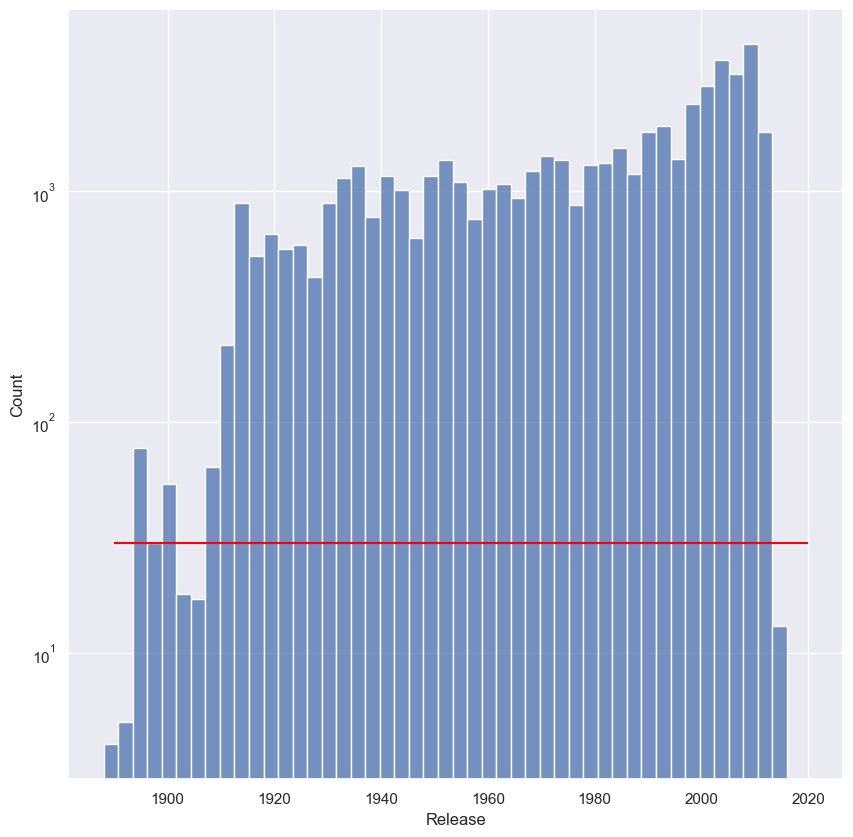

In [70]:
# Plot a histogram of the number of movies vs release, beware the countries columns was previously explode for filtering
sns.histplot(data=processed, x="Release", log_scale=(False,True))
plt.hlines(30, xmin=1890, xmax=2020, colors='red')

In [71]:
# Keep only movies produced between 1913 and 2013 (included) for good statistical analysis
processed = processed[processed["Release"].apply(lambda x: 1912<x<2014)]

**Box Revenue**

Additionally, we studied the box revenue of each movie based on the movie genres from the United States and the United Kingdom, as they represent most of the given movies. Movies with the most significant revenue are linked to epic genres around 2009. After 2009, Superhero movies dominate in the United States.
It would be interesting to look at representation in this genre to see if representation is linked to higher or lower revenue. However, there is a limitation. We only have access to the box office, and thus we weren't able to compare it to the movie investment.

When we looked at global box revenue, we observed the epic genre to have the highest box revenue around the same time (2009). After 2009, we don't have genres that stand out.

## Characters' representation

In [72]:
# Import characters dataset and preprocessing
characters = pd.read_csv('dataset/MovieSummaries/character.metadata.tsv', sep='\t', header=None, 
names = ["WikiID", "FreebaseID", "Release", "Character name", "Birth", 
"Sex", "Height (m)", "Ethnicity", "Name", "Age at movie release",
"Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"])
characters = characters.dropna(subset=["Release", "Sex", "Ethnicity","Age at movie release"])
characters["Release"] = characters["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)
characters["Birth"] = characters["Birth"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)
characters.head()
# We will go from 450'000 to 93'000 rows by droping the ones containing NA values

,WikiID,FreebaseID,Release,Character name,Birth,Sex,Height (m),Ethnicity,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
11,975900,/m/03vyhn,2001,Tres,1959,M,NaN,/m/064b9n,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb
27,3196793,/m/08yl5d,2000,NaN,1937,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp


**Ethnicities**

At first, we had to match FreebaseIDs to comprehensible ethnicities. After doing so, we looked at ethnicity representation across time in movies from top-producing countries. We can see that one ethnicity seems to be very present throughout time. In fact, Indian ethnicity is very present, especially around 2005.  This seemed odd at first since we have previously seen that most movies come from the United States. However, this may be because movies from India list more main characters than other movies. Thus, we decided to look at ethnicity representation throughout time per country. In our graph representing ethnicities in movies from the United States, we see a different representation. It is, therefore, necessary to normalize our data of ethnicities per movie to avoid false assumptions due to different numbers of characters per movie for example.

Then we decided to look at age distribution in function of ethnicities and time. We discovered that most all ethnicities have similar age distributions. Additionally, we wanted to look at age distribution in function of ethnicity and sex. The main observation here was the clear distinction between the male and female actors' age. Moreover, we can see that Indian actresses are much younger than other actresses. It would be interesting to look into this age difference more precisely in future analysis. Furthermore, we should look into the statistical significance of representation differences. Finally, we could compare ethnic representation to the population of the country of origin.

A limitation we have seen is for movies coming from India. In fact, the written ethnicity of most of the actors is Indian. The dataset doesn't go into precise ethnic groups, which makes the analysis vague for most countries.

In [73]:
# Generate the list of different ethnicities
ethnicities = characters['Ethnicity'].dropna().unique().tolist()

In [74]:
if os.path.isfile("data/characters"):
    # To accelerate code execution we will import the pickle file if it exists
    characters = pd.read_pickle("data/characters")
else:
    # Function which allows query search of ids using Wikidata SPARQL service
    def get_ethnicities(ids):

        tmp = '""'.join(ids)

        url = 'https://query.wikidata.org/sparql'
        query = '''
        SELECT  ?ethnicities ?sLabel WHERE {
        VALUES ?ethnicities {"'''+tmp+'''"} 
        ?s wdt:P646 ?ethnicities .

            SERVICE wikibase:label {
            bd:serviceParam wikibase:language "en" .
            }
        }
        '''
        r = requests.post(url, params = {'format': 'json', 'query': query})
        data = r.json()
        return data
    d1 = get_ethnicities(ethnicities[1:200])
    d2 = get_ethnicities(ethnicities[201:478])
    tmp1 = []
    tmp2 = []
    for d in (d1, d2):
        for el in d["results"]["bindings"]:
            tmp1.append(el["ethnicities"]["value"])
            tmp2.append(el["sLabel"]["value"])
    table_eth = pd.DataFrame(tmp1, tmp2).reset_index().rename(columns = {"index": "Ethnicities", 0: "code"})
    # Table associating the freebase id with the ethnicities


    """Code for querying using Google's knowledge graph"""
    import json
    import urllib
    # We are only going to use the Google's KG for the remaining codes that we couldn't find in WikiData 
    ids = list(set(ethnicities) - set(table_eth["code"]))
    # Private api key for using Google's API
    if os.path.isfile("api_key.txt"):
        api_key = open("api_key.txt").read()
        service_url = 'https://kgsearch.googleapis.com/v1/entities:search'
        params = {
            'limit': 500,
            'indent': True,
            'key': api_key,
        }
        url = service_url + '?' + 'ids='+'&ids='.join(ids).replace("/", "%2F" )+'&'+urllib.parse.urlencode(params)
        response = json.loads(urllib.request.urlopen(url).read())
        for element in response['itemListElement']:
            print(element['result']['name'] + ' (' + str(element['result']["@id"]) + ')')
        tmp1 = []
        tmp2 = []
        for element in response['itemListElement']:
            tmp2.append(element['result']['name'])
            tmp1.append(element['result']["@id"].replace("kg:", ''))
        table_eth = pd.concat([table_eth, pd.DataFrame(tmp1, tmp2).reset_index().rename(columns = {"index": "Ethnicities", 0: "code"})])
 

    # Replace ethnicity code by value
    characters["Ethnicity"] = characters["Ethnicity"].apply(lambda x: table_eth["Ethnicities"][table_eth["code"]==x].values[0]
    if any(table_eth["code"]==x) else x)
    characters.to_pickle("data/characters")
characters.head()

,WikiID,FreebaseID,Release,Character name,Birth,Sex,Height (m),Ethnicity,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949,F,1.727,African Americans,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
11,975900,/m/03vyhn,2001,Tres,1959,M,NaN,Omaha people,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb
27,3196793,/m/08yl5d,2000,NaN,1937,M,NaN,African Americans,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp


In [75]:
# Find characters which appear in the movies made by the top producing countries
charac_group = pd.merge(characters[["WikiID", "Release", "Sex", "Ethnicity","Age at movie release", "Birth"]][characters["WikiID"].isin(processed["WikiID"])], processed[["Genres","WikiID", "Countries"]], on=["WikiID"]).reset_index().drop(columns="index")
charac_group.head()

,WikiID,Release,Sex,Ethnicity,Age at movie release,Birth,Genres,Countries
0,975900,2001,F,/m/044038p,27.0,1974,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America]
1,975900,2001,M,African Americans,32.0,1969,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America]
2,975900,2001,F,African Americans,52.0,1949,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America]
3,975900,2001,M,Omaha people,42.0,1959,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America]
4,3196793,2000,M,African Americans,62.0,1937,"[Mystery, Biographical film, Drama, Crime Drama]",[United States of America]


In [76]:
# Utility functions
def count_eth(x): 
    x["Count"] = x["Count"]/x["Count"].sum()
    return x

C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\84519463.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Release").apply(count_eth)
C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\84519463.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Release")

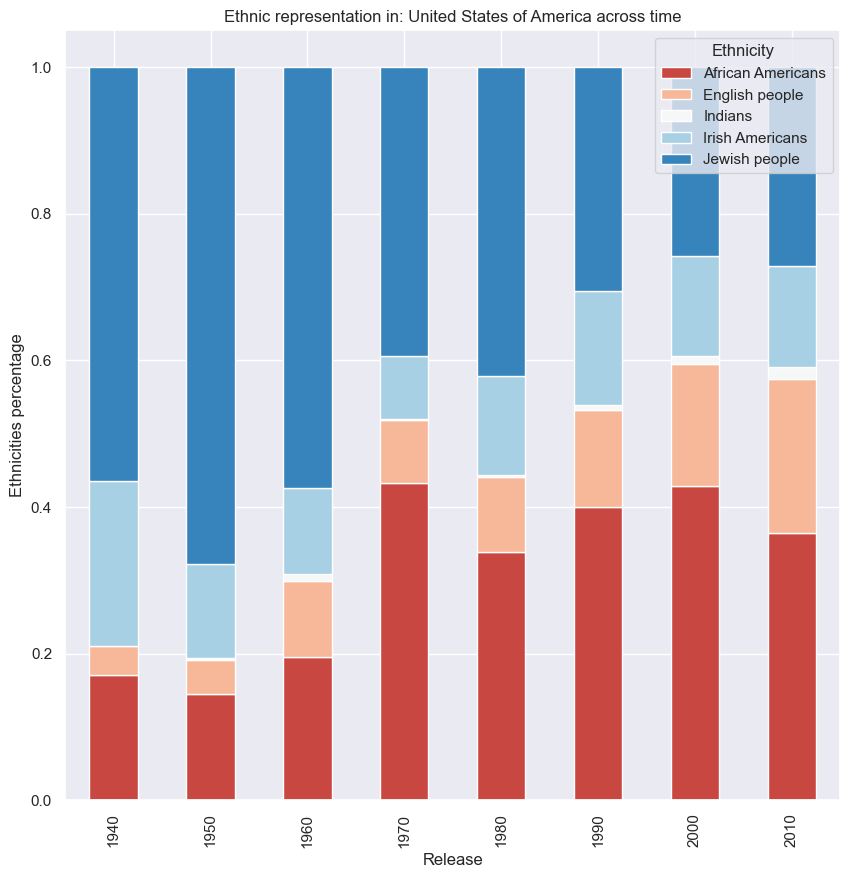

<Figure size 1000x1000 with 0 Axes>

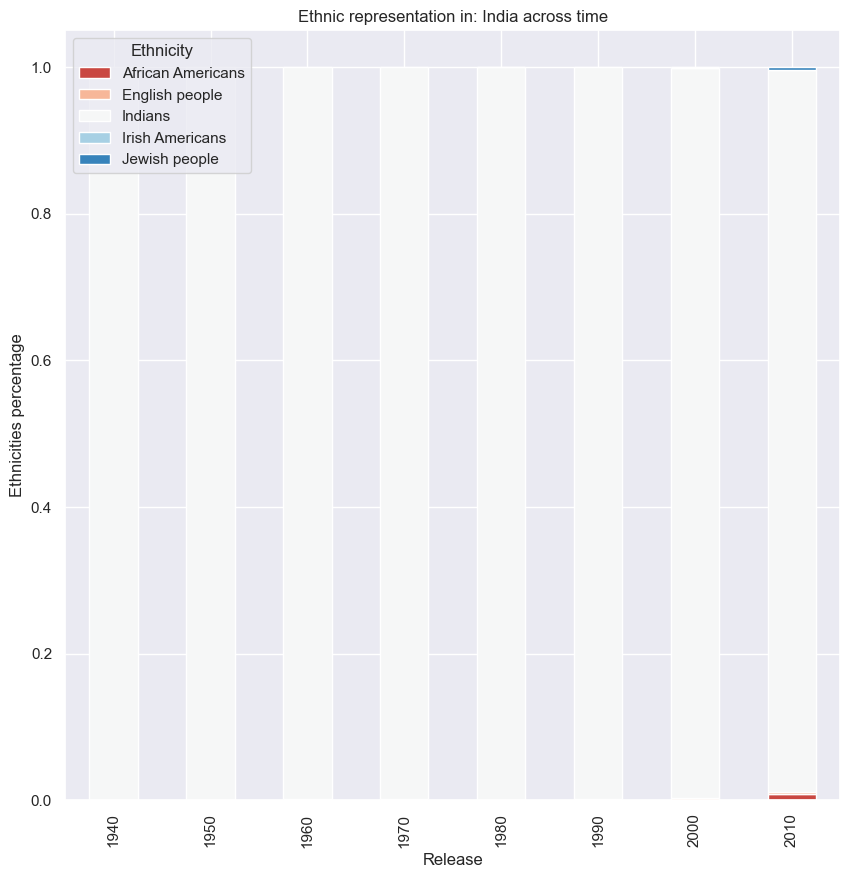

<Figure size 1000x1000 with 0 Axes>

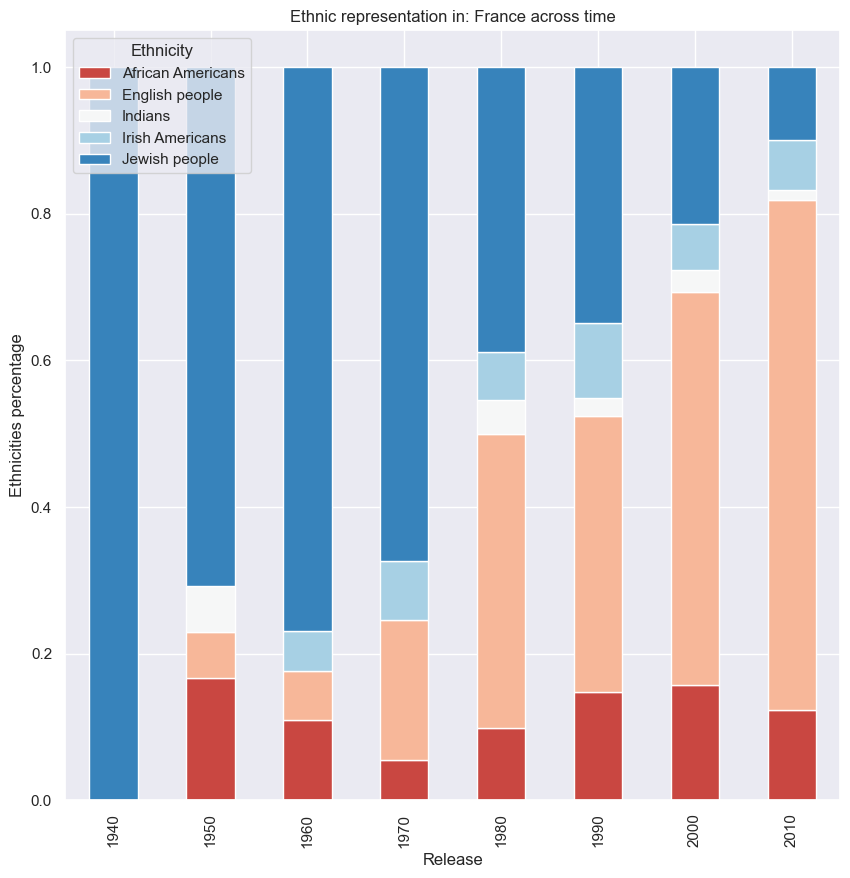

<Figure size 1000x1000 with 0 Axes>

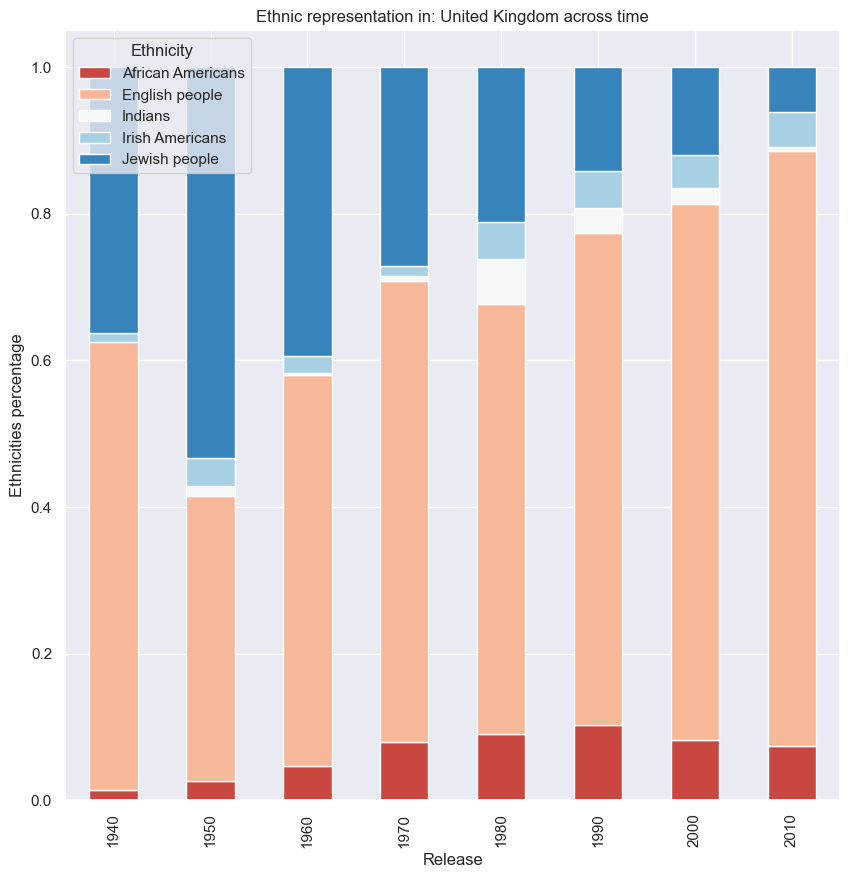

<Figure size 1000x1000 with 0 Axes>

In [77]:
# Generate plot of people of : Ethnic representation accros time
sns.set_palette(sns.color_palette("RdBu",5))

tmp = charac_group
# Keep only the top 5 ethnicities
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]
tmp = tmp[tmp["Release"].apply(lambda x: x>1940)]
for name in ["United States of America", "India", "France", "United Kingdom"]:
    t  = tmp[tmp["Countries"].apply(lambda x: any(e==name for e in x))]
    # Count the number of characters in each subgroup having same: ethnicity and release date
    t=t.groupby(by=["Ethnicity", "Release"]).count().reset_index().rename(columns = {"Countries": "Count"})

    t = t.groupby(by="Release").apply(count_eth)
    t = t.pivot_table(index = 'Release', columns='Ethnicity', values='Count', aggfunc='mean', fill_value=0)
    # Group by decade
    t.groupby((t.index//10)*10).mean().plot(kind = 'bar', stacked = True)
    plt.ylabel("Ethnicities percentage")
    plt.title(f'Ethnic representation in: {name} across time')
    plt.figure()

We had to filter all the people whoose age was >0 as the dataset contains aberrant values (negative). Furthermore, we filtered plotted only the data points for which date>1940 as the previous movies also showed an unexpected behaviour

Text(0.5, 1.0, "Actors' age in function of their nationality and sex across time")

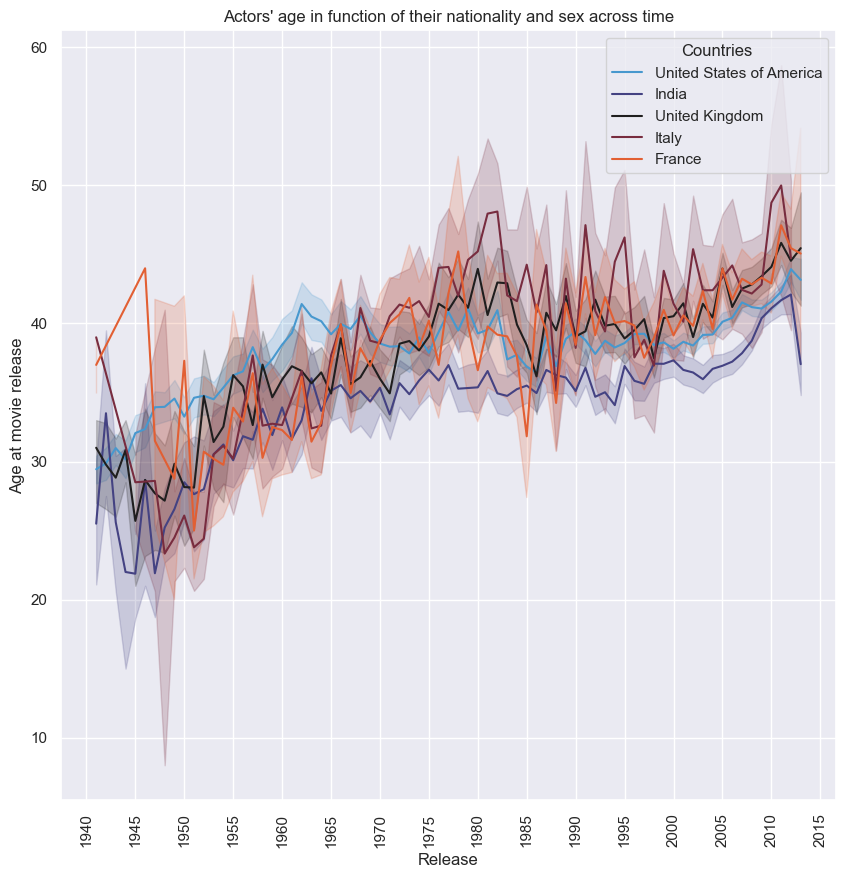

In [78]:
# Plot of age at movie release vs date of film for different countries
sns.set_palette(sns.color_palette("icefire",5))
tmp = charac_group.explode("Countries").reset_index()
tmp = tmp[tmp["Countries"].isin(top[0:5])]

# The data contains aberrant values for the age such as negative or null ones
tmp = tmp[tmp["Age at movie release"]>0]
tmp = tmp[tmp["Release"]>1940]

sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Countries")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)
plt.title("Actors' age in function of their nationality and sex across time")

In [79]:
s = sns.color_palette("RdBu",2)
print(s.as_hex())

['#f7b799', '#a7d0e4']


## New plots

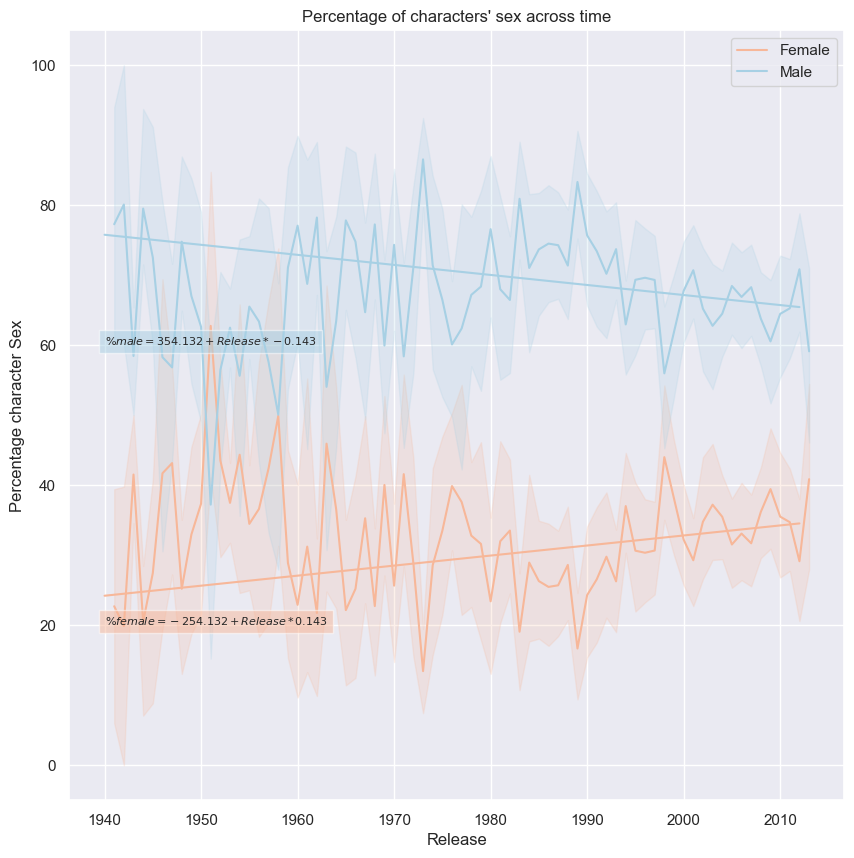

In [80]:
s = sns.color_palette("RdBu",2)
sns.set_palette(s)
R = np.arange(1940,2013,72)

tmp = charac_group.explode("Countries").reset_index()

# Count the percentage of female vs male in the subgroups having the same Countries and Release values
tmp = tmp[tmp["Release"]>1940].groupby(by=["Countries", "Release"]).apply(lambda x: pd.DataFrame({"Female": [(x["Sex"]=="F").sum()/x["Sex"].count()*100],
"Male": [(x["Sex"]=="M").sum()/x["Sex"].count()*100]})).reset_index().drop(columns="level_2")
tmp.head()

sns.lineplot(data=tmp, x="Release", y="Female", label="Female")

sns.lineplot(data=tmp, x="Release", y="Male", label="Male")
tmp = tmp[tmp["Release"]>1960]
plt.ylabel("Percentage character Sex")
plt.title("Percentage of characters' sex across time")

# Fit linear regression on curves
mod = smf.ols(formula='Male ~ Release', data=tmp)
np.random.seed(2)
resM = mod.fit()
betaM = resM.params
mod = smf.ols(formula='Female ~ Release', data=tmp)
np.random.seed(2)
resF = mod.fit()
betaF = resF.params
plt.text(1940, 60, f'$\%male =  {np.round(betaM[0],3)}+Release * {np.round(betaM[1], 3)}$', fontsize = 8, 
         bbox = dict(facecolor = s.as_hex()[1], alpha = 0.5))
plt.text(1940, 20, f'$\%female = {np.round(betaF[0],3)}+Release * {np.round(betaF[1],3)}$', fontsize = 8, 
         bbox = dict(facecolor = s.as_hex()[0], alpha = 0.5))
plt.plot(R, R*betaF[1]+betaF[0])


plt.plot(R, R*betaM[1]+betaM[0])

plt.show()

In [81]:
print(resM.summary())

                            OLS Regression Results                            
Dep. Variable:                   Male   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     8.718
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00320
Time:                        23:03:37   Log-Likelihood:                -6610.6
No. Observations:                1417   AIC:                         1.323e+04
Df Residuals:                    1415   BIC:                         1.324e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    354.1324     96.852      3.656      0.0

In [82]:
print(resF.summary())

                            OLS Regression Results                            
Dep. Variable:                 Female   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     8.718
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00320
Time:                        23:03:37   Log-Likelihood:                -6610.6
No. Observations:                1417   AIC:                         1.323e+04
Df Residuals:                    1415   BIC:                         1.324e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -254.1324     96.852     -2.624      0.0

C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\3080511848.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940]


Text(0.5, 1.0, 'Actors age in function of their nationality and sex across time')

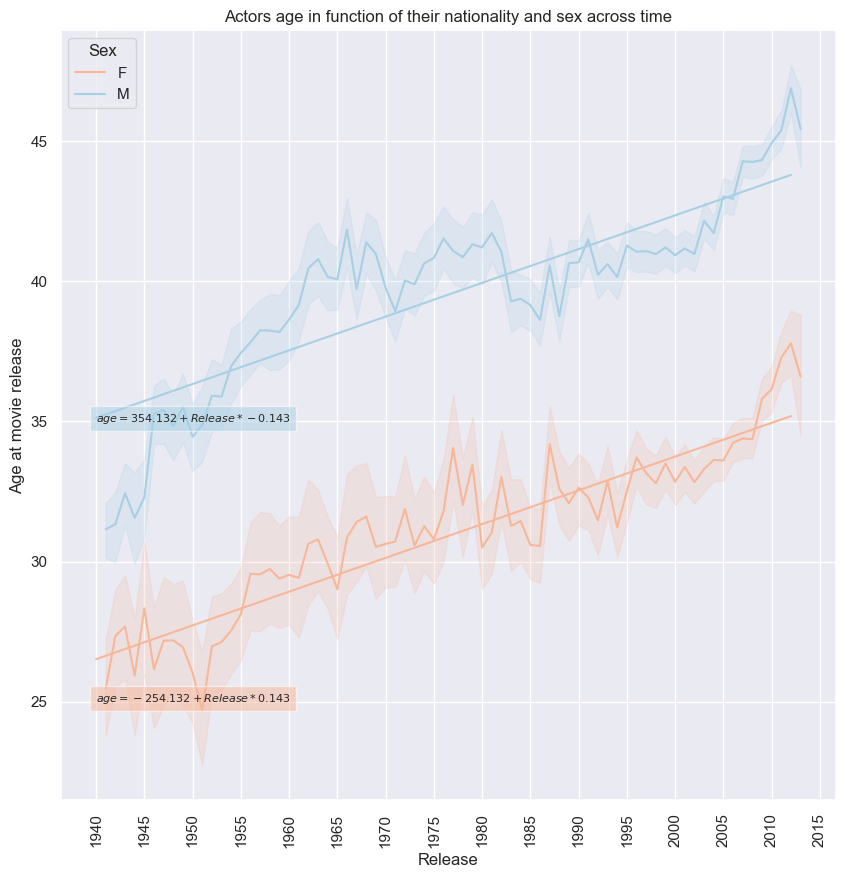

In [83]:
# Plot of age at movie release vs date of film for different countries/sex
sns.set_palette(sns.color_palette("RdBu",2))

tmp = charac_group
tmp = tmp[tmp["Age at movie release"]>0][tmp["Release"]>1940]

sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Sex")


tmp = tmp.rename(columns={"Age at movie release": "Age"})

# Perform regression analysis

# Declares the model
mod = smf.ols(formula='Age ~ Release', data=tmp[tmp["Sex"].isin(["M"])])

np.random.seed(2)
resM = mod.fit()
mod = smf.ols(formula='Age ~ Release', data=tmp[tmp["Sex"].isin(["F"])])
beta_age_M = resM.params

np.random.seed(2)
resF = mod.fit()
beta_age_F = resF.params

plt.plot(R, R*beta_age_M[1]+beta_age_M[0])

plt.plot(R, R*beta_age_F[1]+beta_age_F[0])
plt.text(1940, 35, f'$age =  {np.round(betaM[0],3)}+Release * {np.round(betaM[1], 3)}$', fontsize = 8, 
         bbox = dict(facecolor = s.as_hex()[1], alpha = 0.5))
plt.text(1940, 25, f'$age = {np.round(betaF[0],3)}+Release * {np.round(betaF[1],3)}$', fontsize = 8, 
         bbox = dict(facecolor = s.as_hex()[0], alpha = 0.5))
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=20)
plt.title('Actors age in function of their nationality and sex across time')

In [84]:
print(resF.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     582.9
Date:                Thu, 22 Dec 2022   Prob (F-statistic):          1.82e-127
Time:                        23:03:41   Log-Likelihood:            -1.1051e+05
No. Observations:               27711   AIC:                         2.210e+05
Df Residuals:                   27709   BIC:                         2.211e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -207.3575      9.961    -20.817      0.0

In [85]:
print(resF.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     582.9
Date:                Thu, 22 Dec 2022   Prob (F-statistic):          1.82e-127
Time:                        23:03:41   Log-Likelihood:            -1.1051e+05
No. Observations:               27711   AIC:                         2.210e+05
Df Residuals:                   27709   BIC:                         2.211e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -207.3575      9.961    -20.817      0.0

C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\1905730674.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Sex").apply(count_eth)
C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\1905730674.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Genres").

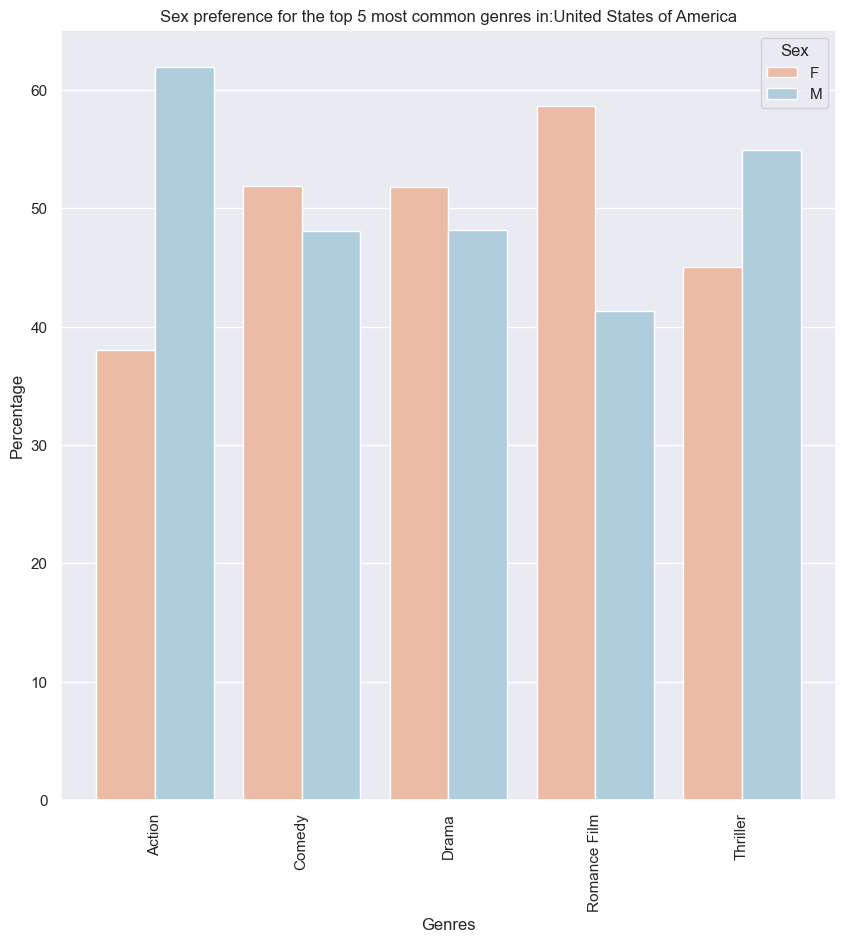

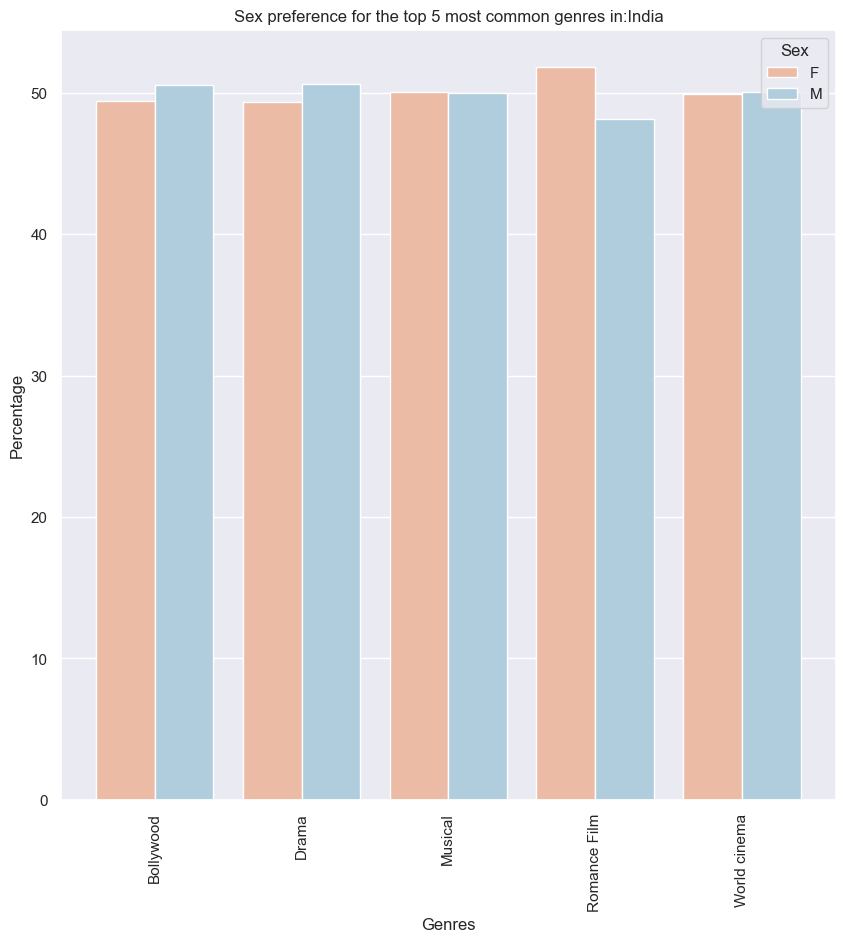

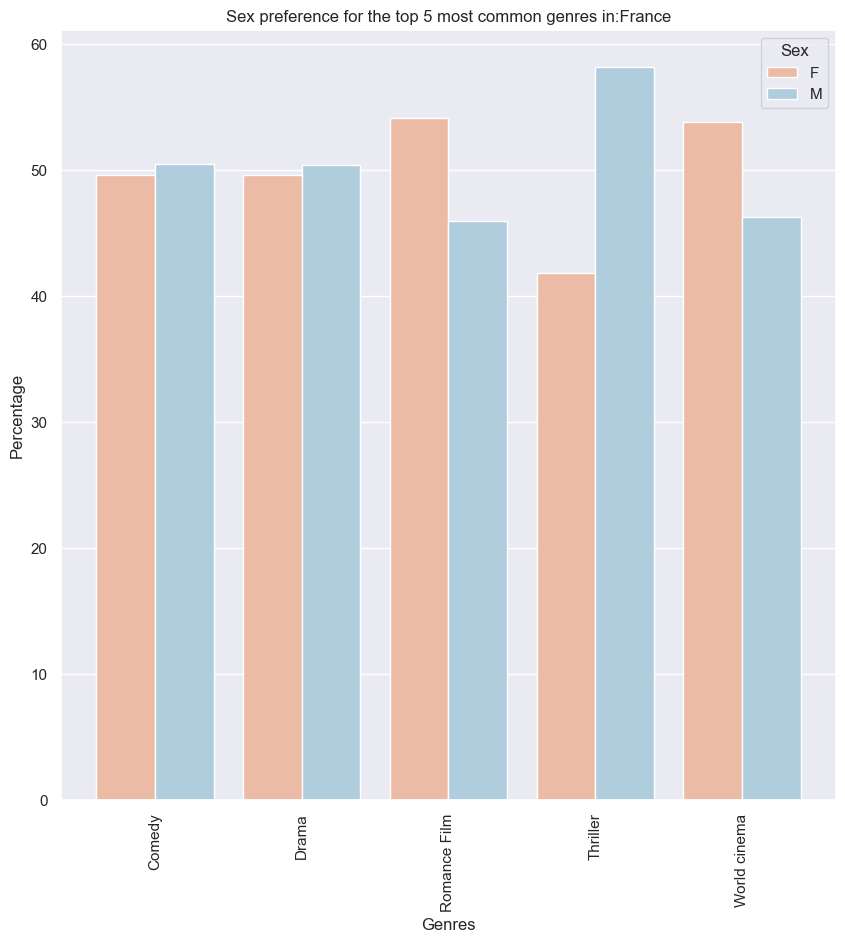

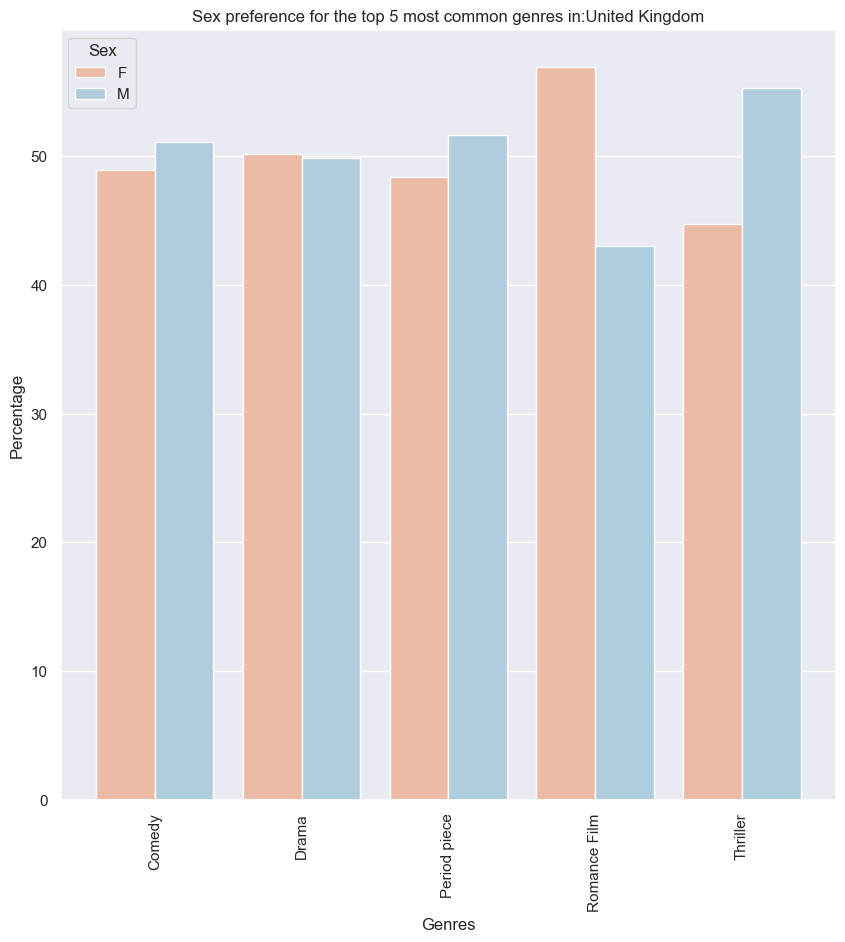

<Figure size 1000x1000 with 0 Axes>

In [86]:
# Generate plot of age of people of different ethnicities vs the date of release
sns.set_palette(sns.color_palette("RdBu",2))
tmp = charac_group.explode(column="Genres").dropna(subset=["Genres"])
tmp = tmp[tmp["Age at movie release"]>0]
tmp = tmp[tmp["Release"]>1940]

for name in ["United States of America", "India", "France", "United Kingdom"]:
    t  = tmp[tmp["Countries"].apply(lambda x: any(e==name for e in x))]


    t = t[t["Genres"].isin(t["Genres"].value_counts().nlargest(5).index)]
    t=t.groupby(by=["Sex", "Genres"]).count().reset_index().rename(columns = {"Countries": "Count"})
    # Normalize by sex (as there are more males than females) and genres
    t = t.groupby(by="Sex").apply(count_eth)
    t = t.groupby(by="Genres").apply(count_eth)
    t["Count"] = t["Count"]*100


    sns.barplot(data=t, x = "Genres", y="Count", hue="Sex")
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=20)
    plt.ylabel("Percentage")
    plt.title(f'Sex preference for the top 5 most common genres in:{name}')
    plt.figure()

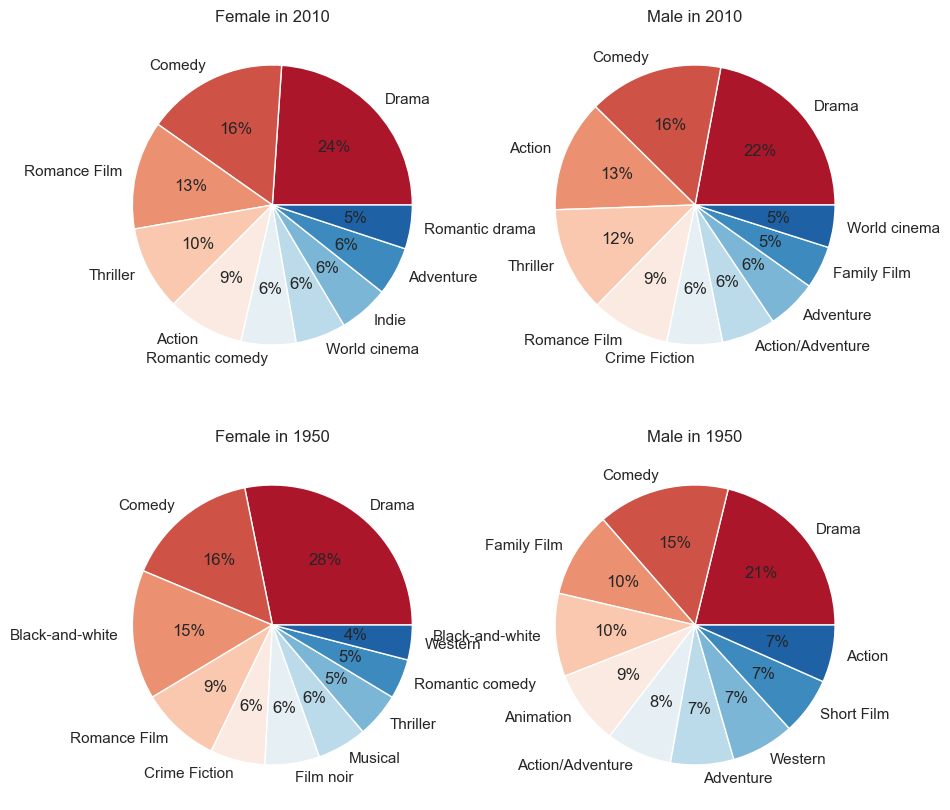

In [87]:
# Plot the genres distribution for female and male
# Normalized only by genre 
sns.set_palette(sns.color_palette("RdBu",10))

tmp = charac_group.explode("Genres").dropna(subset="Genres")
tmp1 = tmp[tmp["Sex"].isin(["F"])]
tmp = tmp[tmp["Sex"].isin(["M"])]

tmp3 = tmp1[tmp1["Release"]==1950]["Genres"].value_counts().nlargest(10)
tmp1 = tmp1[tmp1["Release"]==2010]["Genres"].value_counts().nlargest(10)

tmp4 = tmp[tmp["Release"]==1950]["Genres"].value_counts().nlargest(10)
tmp = tmp[tmp["Release"]==2010]["Genres"].value_counts().nlargest(10)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.set_facecolor('None')

ax1.pie(tmp1.values, labels=tmp1.index, autopct='%.0f%%')
ax2.pie(tmp.values, labels=tmp.index, autopct='%.0f%%')
ax3.pie(tmp3.values, labels=tmp3.index, autopct='%.0f%%')
ax4.pie(tmp4.values, labels=tmp4.index, autopct='%.0f%%')
ax1.title.set_text('Female in 2010')
ax2.title.set_text('Male in 2010')
ax3.title.set_text('Female in 1950')
ax4.title.set_text('Male in 1950')
plt.savefig("pie.png", transparent=True)

plt.show()

In [88]:
l = processed.explode("Genres")["Genres"].dropna().unique()
l.sort()
l = [s.lower() for s in l]
matching = [s for s in l if "sex" in s]

In [89]:
lgbt = ["gay", "gay interest", "gay themed", "lgbt"]
porno = ['gay pornography',
 'hardcore pornography',
 'pornographic movie',
 'pornography',
 'softcore porn']

Text(0.5, 1.0, 'Percentage of LGBT films across time')

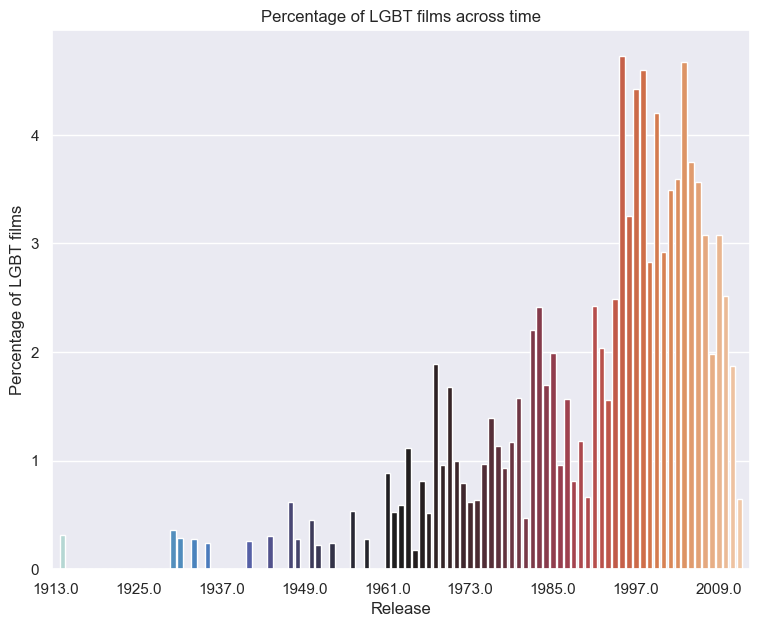

In [90]:

# Plot the evolution of the % of LGBT themed movies across
tmp = processed

tmp = tmp.groupby("Release").apply(lambda x: pd.DataFrame({"LGBT": [x["Genres"].apply(lambda y: any(e.lower() in lgbt for e in y)).sum()/x["Genres"].count()*100]})).reset_index().drop(columns="level_1")


plt.figure(figsize=(9,7))

sns.barplot(data=tmp, x= "Release", y="LGBT", palette="icefire")
plt.ylabel("Percentage of LGBT films")
plt.xticks(np.arange(0, 100 + 1, 12))
plt.title("Percentage of LGBT films across time")


C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\2529782773.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Release").apply(count_eth)
C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\2529782773.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Relea

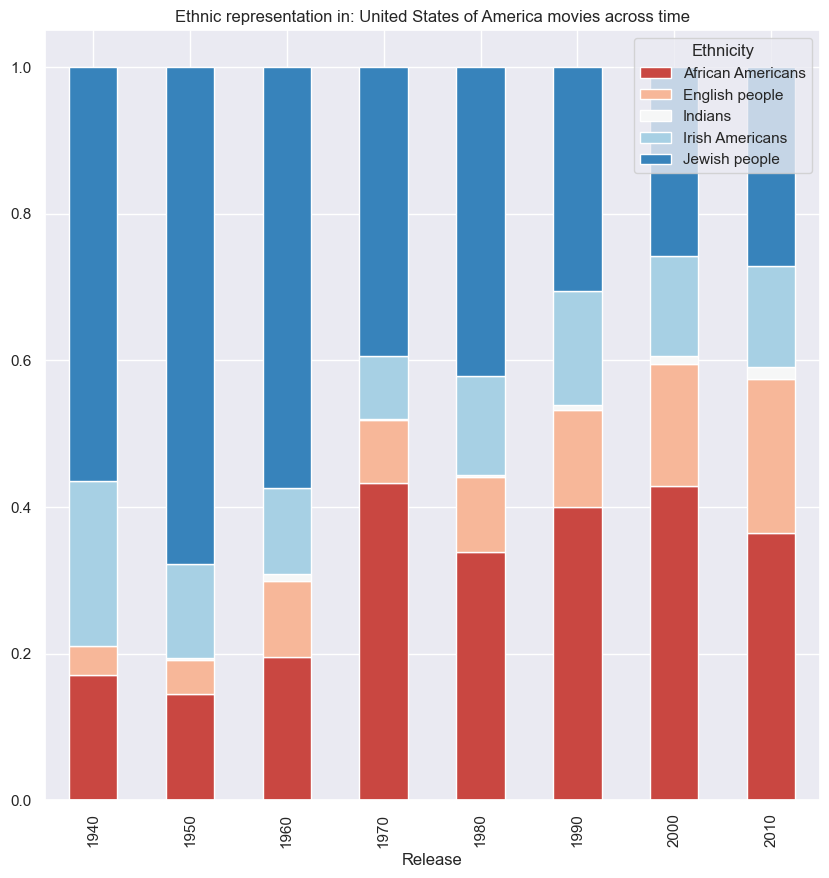

<Figure size 1000x1000 with 0 Axes>

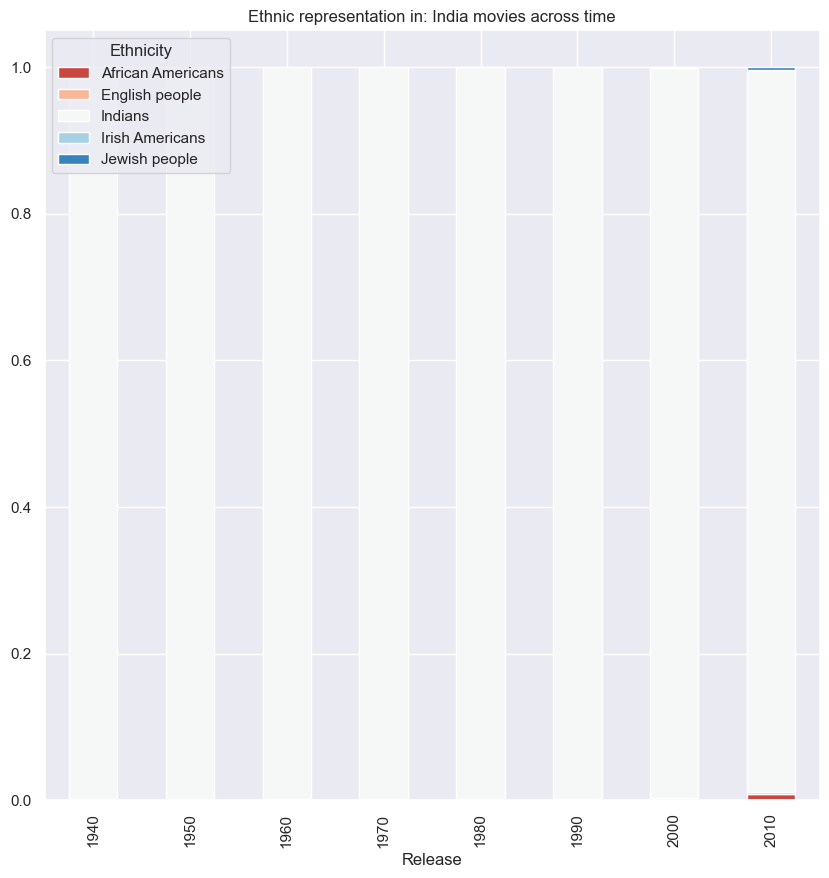

<Figure size 1000x1000 with 0 Axes>

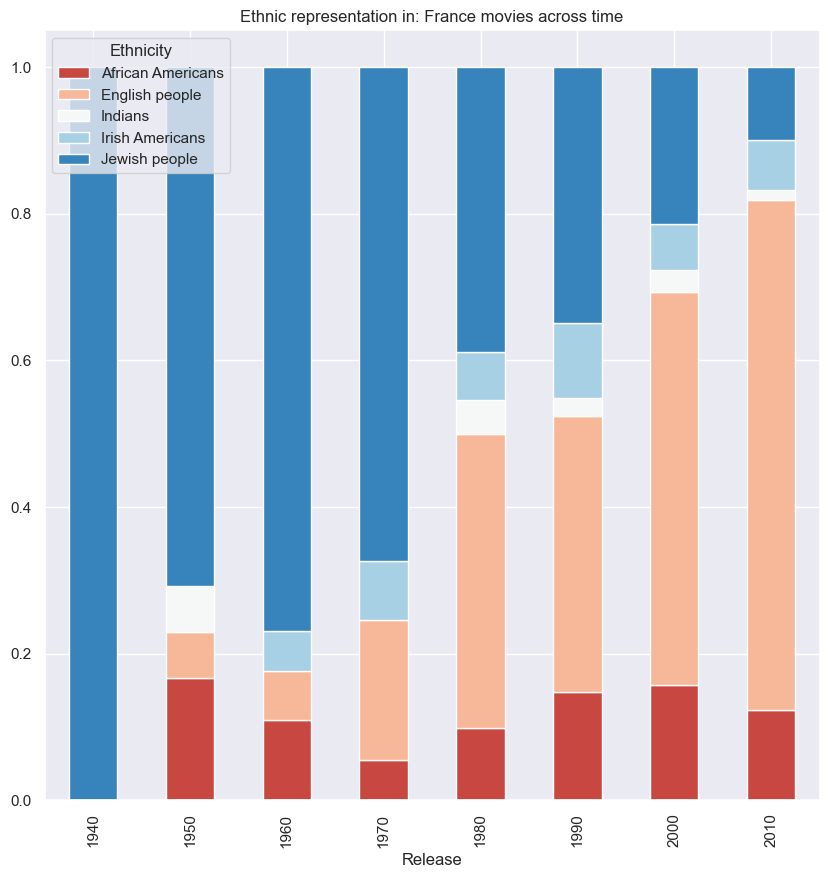

<Figure size 1000x1000 with 0 Axes>

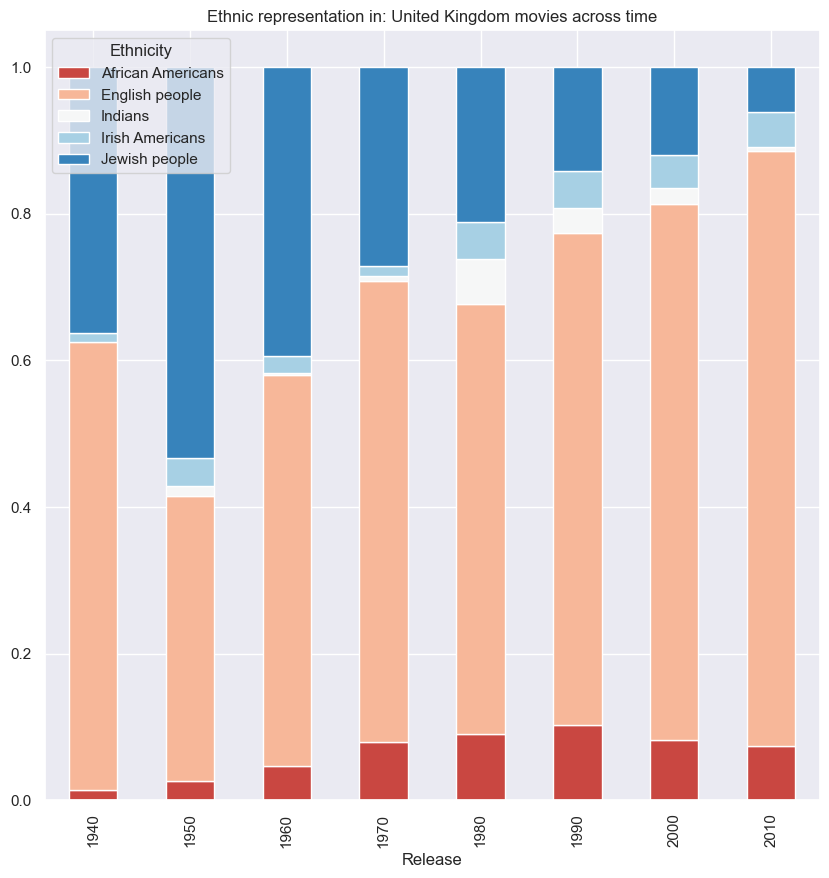

<Figure size 1000x1000 with 0 Axes>

In [91]:
# Generate plot of people of different ethnicities vs the date of release
sns.set_palette(sns.color_palette("RdBu",5))

tmp = charac_group
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]
tmp = tmp[tmp["Release"].apply(lambda x: x>1940)]

for name in ["United States of America", "India", "France", "United Kingdom"]:

    t  = tmp[tmp["Countries"].apply(lambda x: any(e==name for e in x))]
    # Group by ethnicity and release and count
    t=t.groupby(by=["Ethnicity", "Release"]).count().reset_index().rename(columns = {"Countries": "Count"})
    # Count the ethnicity in each subgroup having the same release value
    t = t.groupby(by="Release").apply(count_eth)

    t = t.pivot_table(index = 'Release', columns='Ethnicity', values='Count', aggfunc='mean', fill_value=0)
    t.groupby((t.index//10)*10).mean().plot(kind = 'bar', stacked = True)
    plt.title(f'Ethnic representation in: {name} movies across time')
    plt.figure()

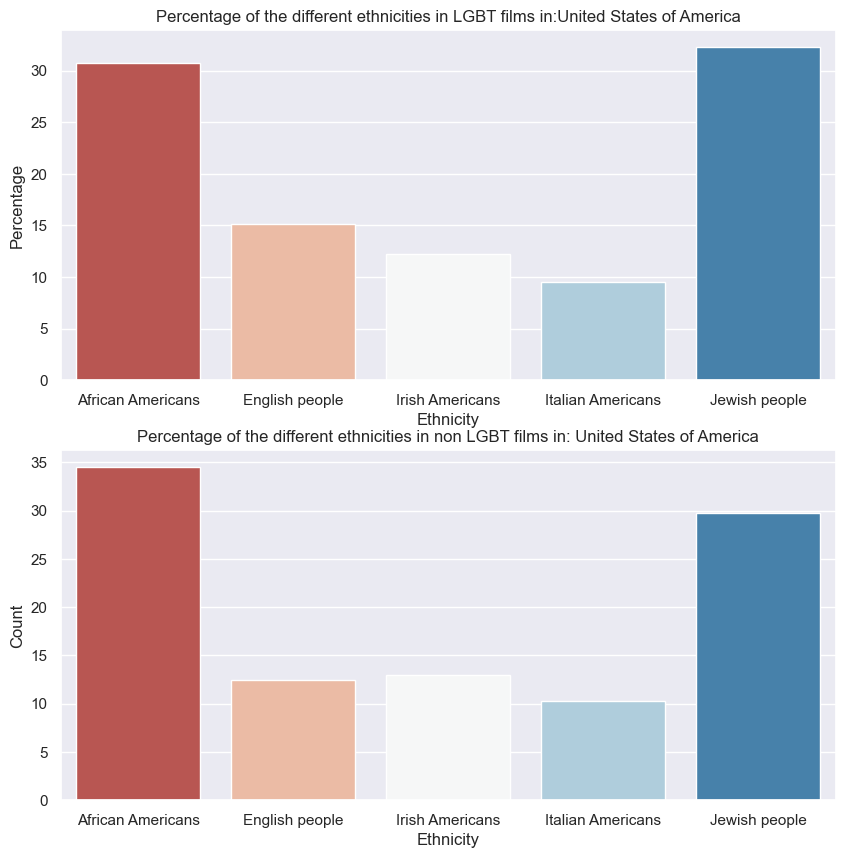

<Figure size 1000x1000 with 0 Axes>

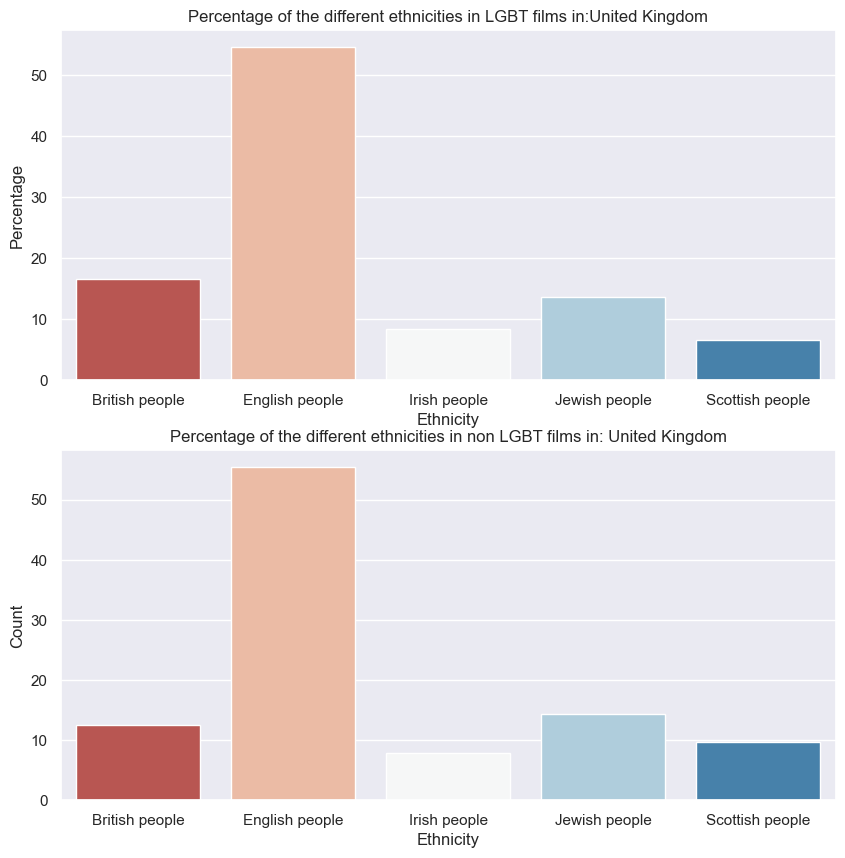

<Figure size 1000x1000 with 0 Axes>

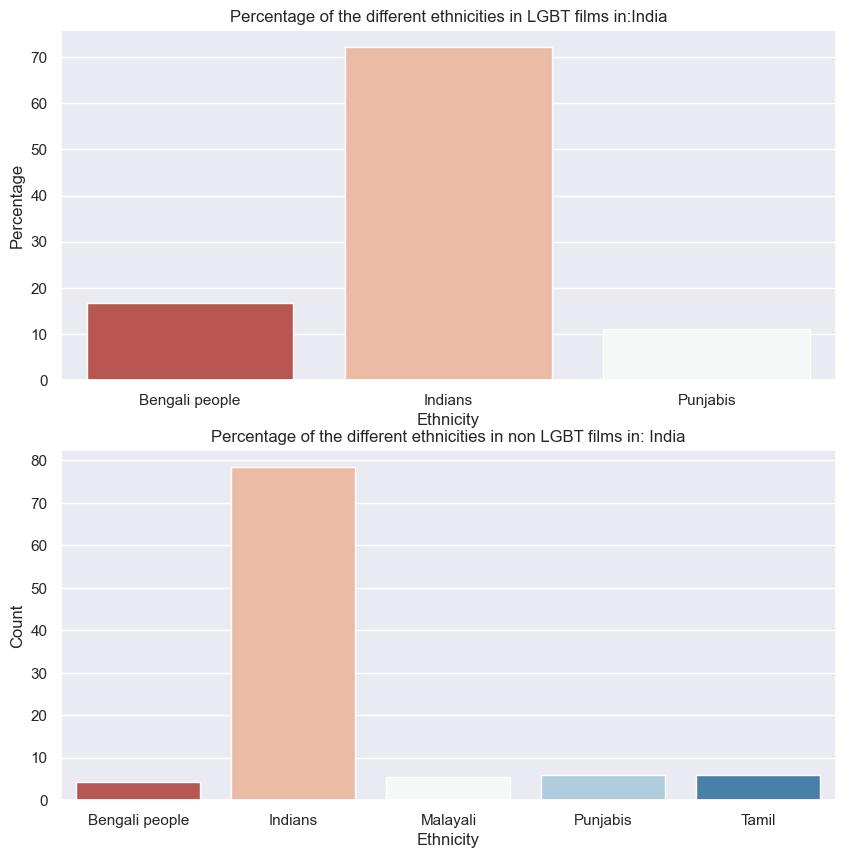

<Figure size 1000x1000 with 0 Axes>

In [92]:
# Percentage of the different ethnicities in LGBT films in the US
for name in ["United States of America", "United Kingdom", "India"]:
    t= charac_group
    t = t[t["Countries"].apply(lambda x: any(e==name for e in x))]
    t = t[t["Ethnicity"].isin(t["Ethnicity"].value_counts().nlargest(5).index)]
    
   
    tmp= t[~t["Genres"].apply(lambda x: any(e.lower() in lgbt for e in x))]
    t= t[t["Genres"].apply(lambda x: any(e.lower() in lgbt for e in x))]
    fig, axs = plt.subplots(2)

    for (id, el) in enumerate([t, tmp]):   
        el=el.groupby(by=["Ethnicity"]).count().reset_index().rename(columns = {"Birth": "Count"})
        # Calculate the percentages of ethnicites in lgbt films
        el["Count"] = el["Count"]/el["Count"].sum()*100   

        axs[id] = sns.barplot(data=el, x= "Ethnicity", y = "Count", ax = axs[id])
        axs[0].set_ylabel('Percentage')

    axs[0].set_title(f"Percentage of the different ethnicities in LGBT films in:{name}")
    axs[1].set_title(f"Percentage of the different ethnicities in non LGBT films in: {name}")

    
    plt.figure()


C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\3063153364.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tmp = tmp.groupby(by=["Release", "Genres"]).apply(lambda x: pd.DataFrame(x["Sex"].value_counts(


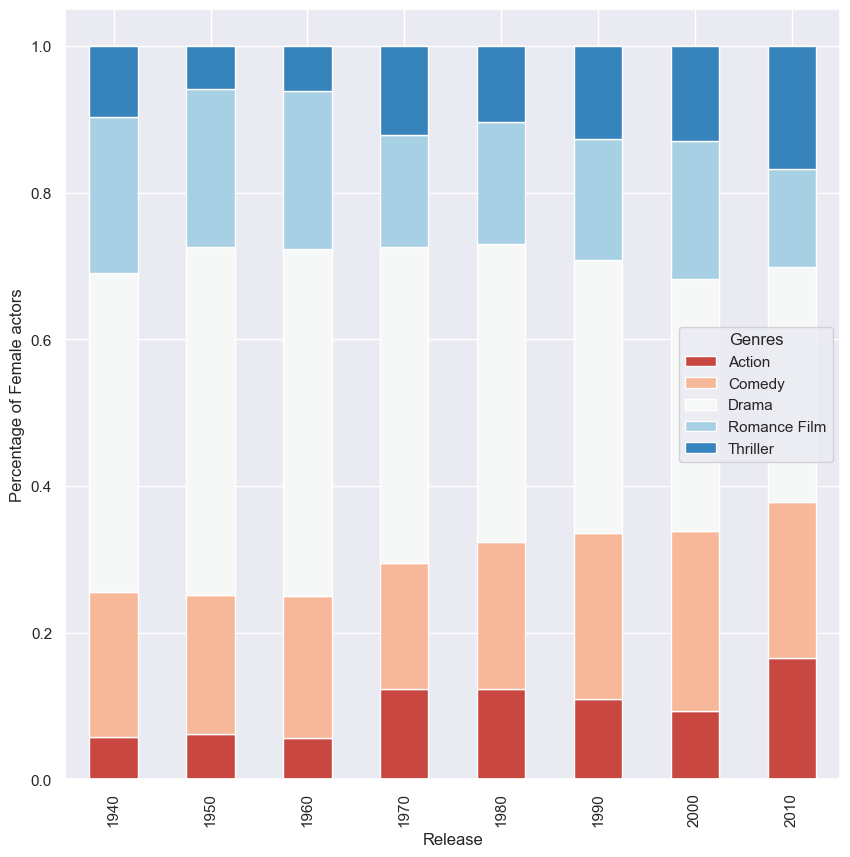

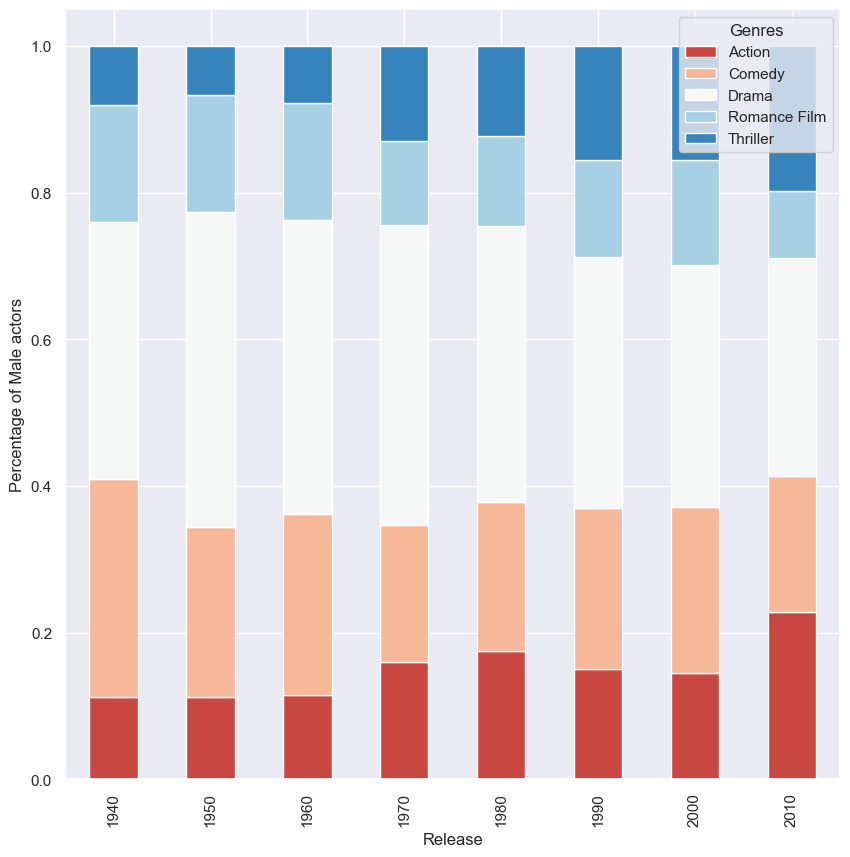

In [93]:
# Distribution of characters in different genres according to their sex
tmp = charac_group.explode("Genres").dropna(subset="Genres")
tmp = tmp[tmp["Release"]>1940]
tmp= tmp[tmp["Genres"].isin(tmp["Genres"].value_counts().nlargest(5).index)]


tmp = tmp.groupby(by=["Release", "Genres"]).apply(lambda x: pd.DataFrame(x["Sex"].value_counts(
)).reset_index().pivot_table(columns="index")).reset_index().rename(columns ={"F": "Female", "M":"Male"}).groupby(by=["Release"]).apply(lambda x: pd.concat([x["Release"],x["Genres"],x["Female"]/x["Female"].sum(), x["Male"]/x["Male"].sum()], axis=1))

for sex in ["Female", "Male"]:
    t = tmp
    t = t.pivot_table(index = 'Release', columns='Genres', values=sex, aggfunc='mean')
    t.groupby((t.index//10)*10).mean().plot(kind = 'bar', stacked = True)
    plt.ylabel(f"Percentage of {sex} actors")

C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\4127584192.py:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tmp = tmp.groupby(by="Release").apply(count_eth)


Text(0.5, 1.0, 'Ethnic representation in US movies across time')

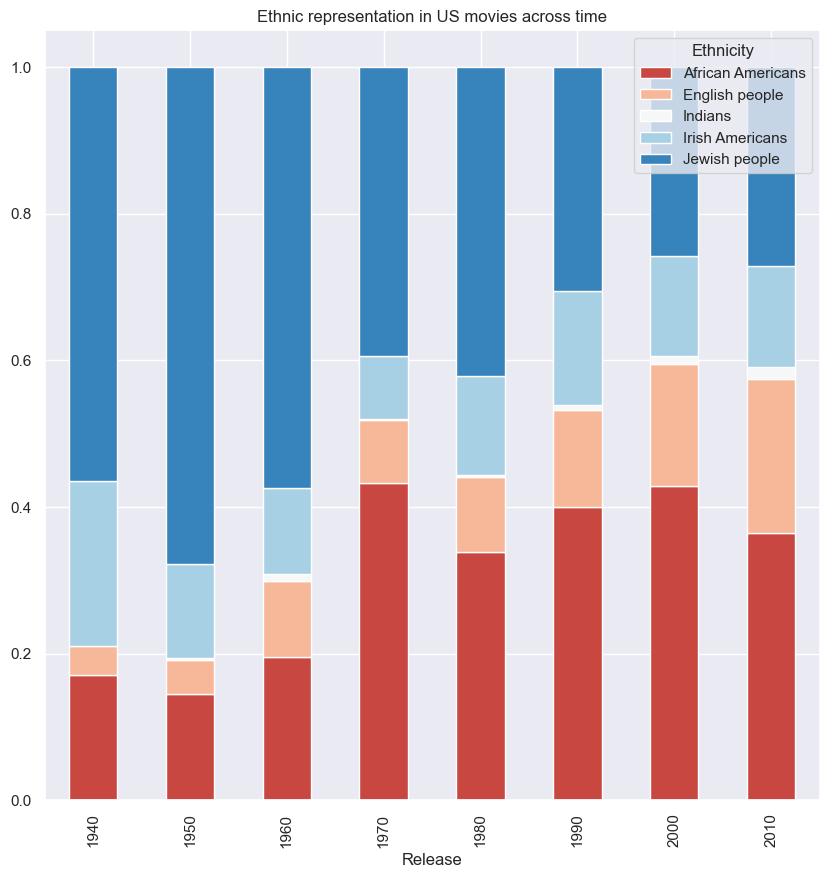

In [94]:
# Generate plot of people of different ethnicities vs the date of release
tmp = charac_group
tmp = tmp[tmp["Ethnicity"].isin(tmp["Ethnicity"].value_counts().nlargest(5).index)]
tmp = tmp[tmp["Release"].apply(lambda x: x>1940)]
tmp  = tmp[tmp["Countries"].apply(lambda x: any(e=="United States of America" for e in x))]

tmp=tmp.groupby(by=["Ethnicity", "Release"]).count().reset_index().rename(columns = {"Countries": "Count"})

tmp = tmp.groupby(by="Release").apply(count_eth)

tmp = tmp.pivot_table(index = 'Release', columns='Ethnicity', values='Count', aggfunc='mean', fill_value=0)
tmp.groupby((tmp.index//10)*10).mean().plot(kind = 'bar', stacked = True)
plt.title('Ethnic representation in US movies across time')

C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\2785312507.py:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Ethnicity").apply(count_eth)
C:\Users\nico9\AppData\Local\Temp\ipykernel_21604\2785312507.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  t = t.groupby(by="Gen

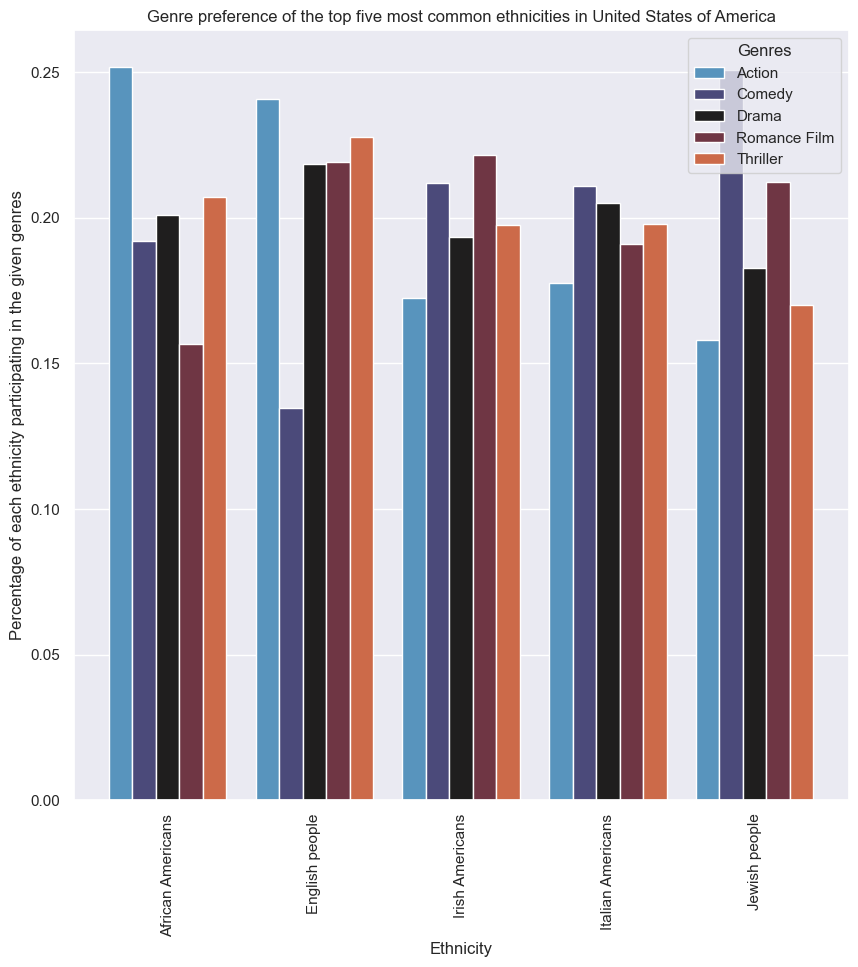

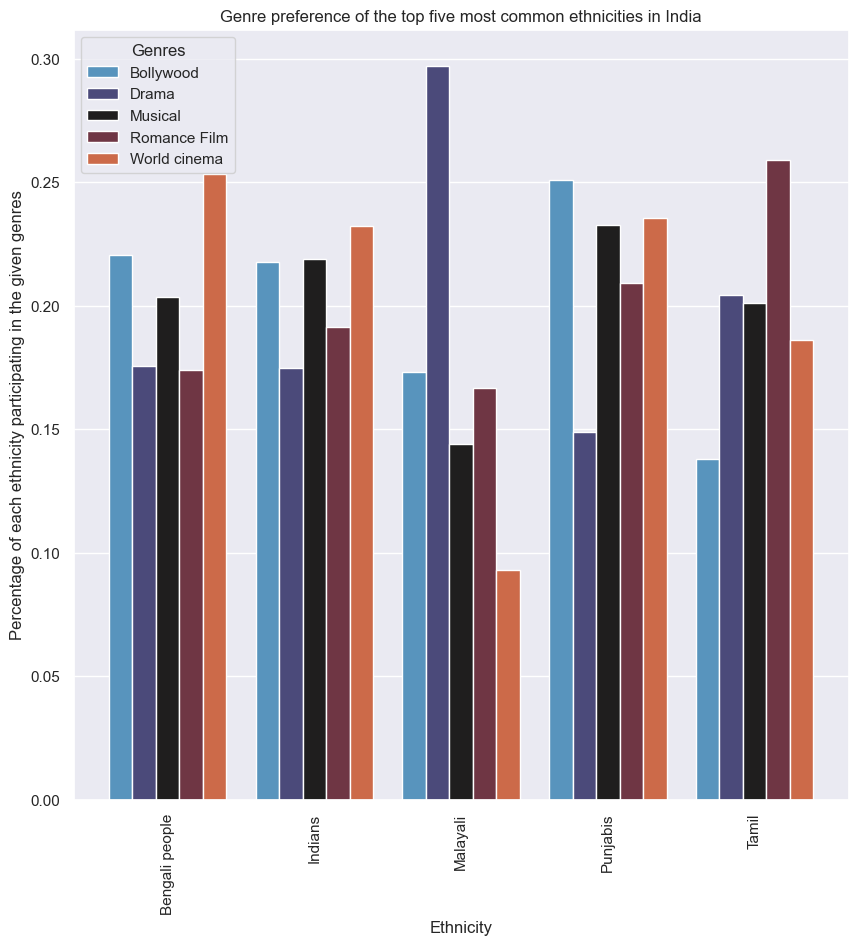

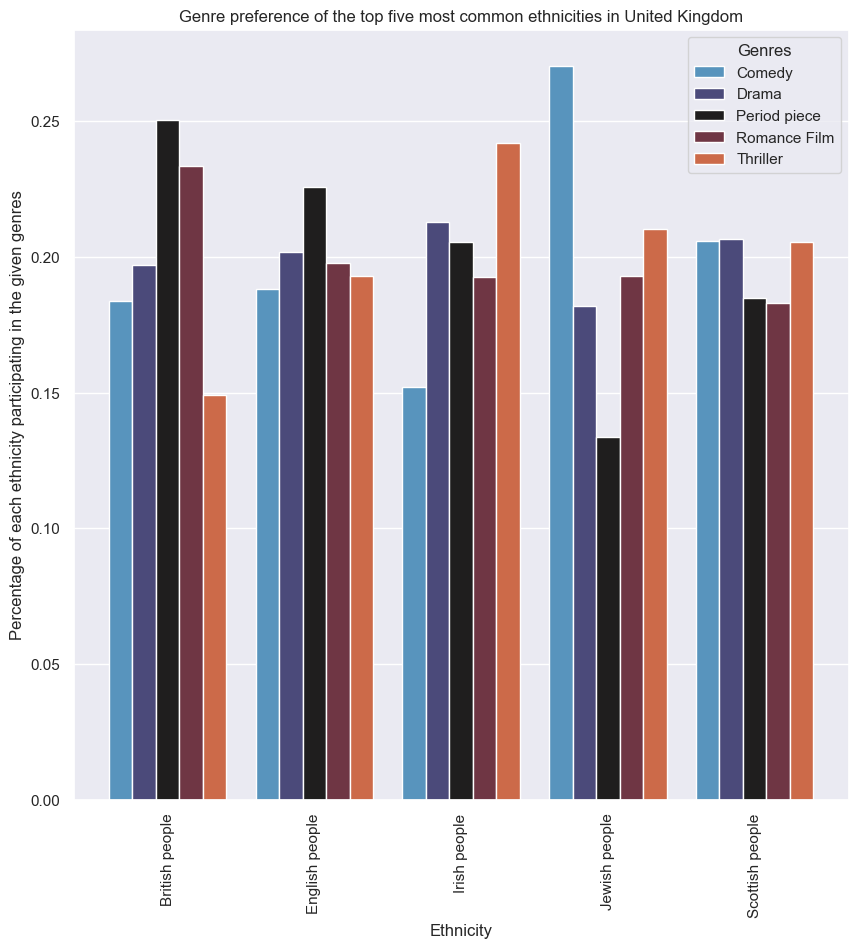

<Figure size 1000x1000 with 0 Axes>

In [95]:
# Plot of the genres distribution according to ethnicity
sns.set_palette(sns.color_palette("icefire",5))

tmp = charac_group.explode(column="Genres").dropna(subset=["Genres"])
tmp = tmp[tmp["Age at movie release"]>0]
tmp = tmp[tmp["Release"]>1940]

for name in ["United States of America", "India", "United Kingdom"]:
    t = tmp[tmp["Countries"].apply(lambda x: any(e==name for e in x))]
    t = t[t["Ethnicity"].isin(t["Ethnicity"].value_counts().nlargest(5).index)]
    t = t[t["Genres"].isin(t["Genres"].value_counts().nlargest(5).index)]
    t=t.groupby(by=["Genres", "Ethnicity"]).count().reset_index().rename(columns = {"Countries": "Count"})
    # Normalize by ethnicity and genre
    t = t.groupby(by="Ethnicity").apply(count_eth)
    t = t.groupby(by="Genres").apply(count_eth)

    sns.barplot(data=t, x = "Ethnicity", y="Count", hue="Genres")
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=20)
    plt.ylabel("Percentage of each ethnicity participating in the given genres")
    plt.title(f'Genre preference of the top five most common ethnicities in {name}')
    plt.figure()

Text(0.5, 1.0, 'Box revenue UK')

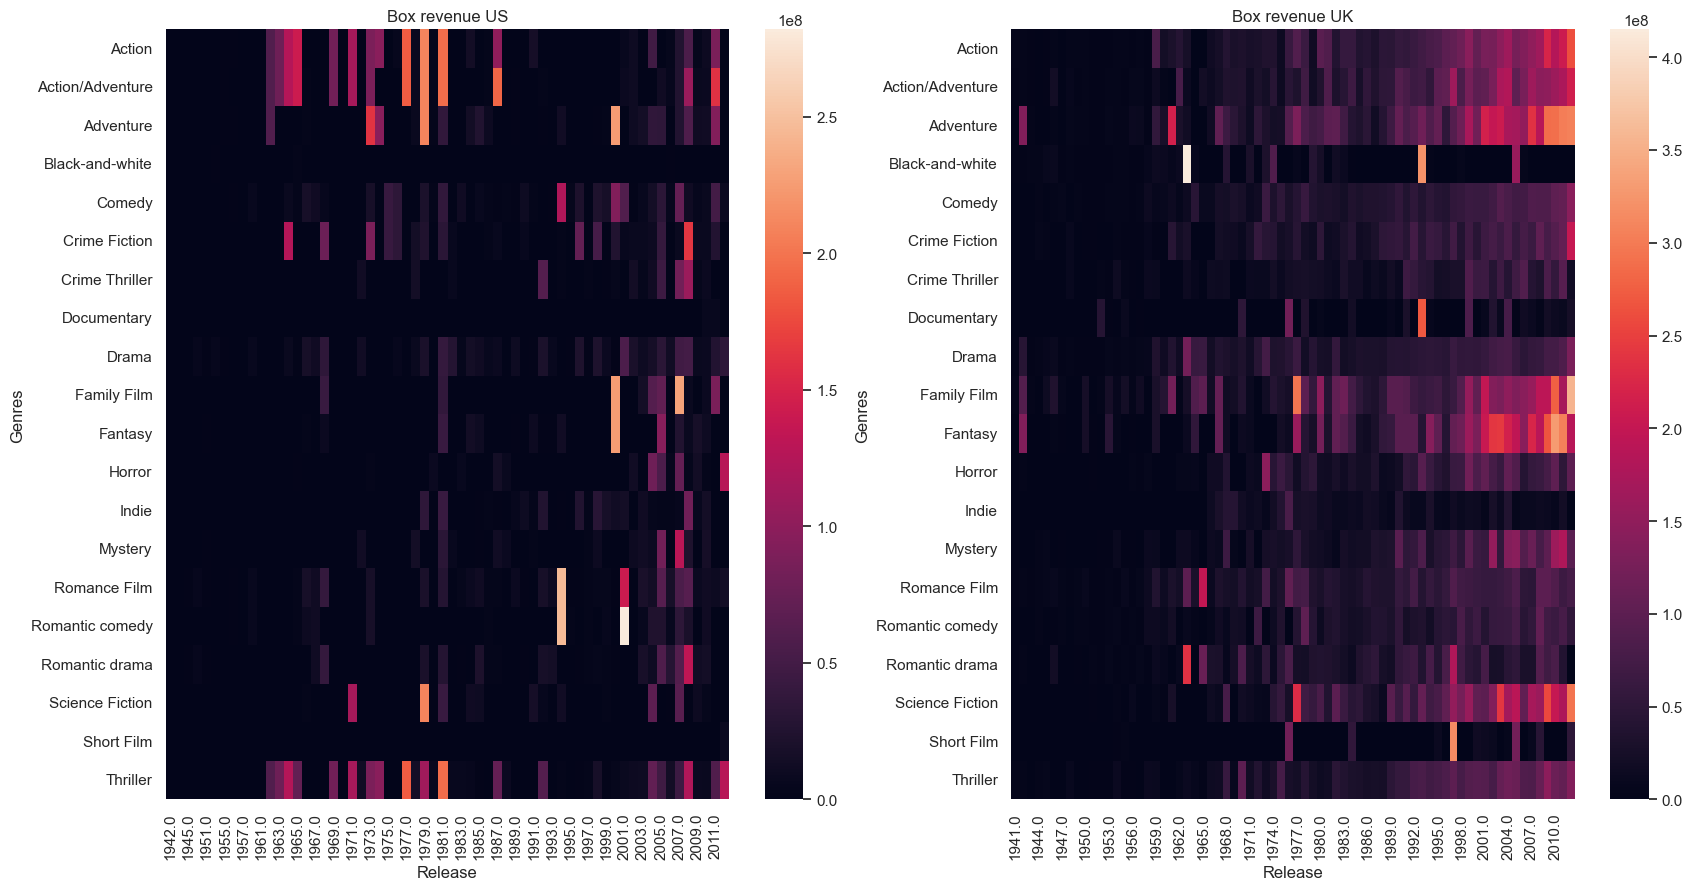

In [96]:
# Box revenue of genres vs release date for the US
tmp = processed[processed["Countries"].apply(lambda x: any(e in ["United States of America", "United Kingdom"] for e in x))].explode("Genres")
tmp = tmp[tmp["Release"]>1940]
tmp = tmp[tmp["Genres"].isin(tmp["Genres"].value_counts().nlargest(20).index)]
temp = tmp[tmp["Countries"].apply(lambda x: any(e=="United States of America" for e in x))]
tmp = tmp[~tmp["Countries"].apply(lambda x: any(e=="United States of America" for e in x))]
tmp = tmp.pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)

# Box revenue of genres vs release date for the UK
temp = temp.pivot_table(index = 'Genres', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)

# The max values has been fixed at 1.5e9
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20, 10))
ax1 = sns.heatmap(tmp, ax = ax1)
ax1.set_title("Box revenue US")
ax2 = sns.heatmap(temp, ax=ax2)
ax2.set_title("Box revenue UK")


<AxesSubplot: xlabel='Release', ylabel='Countries'>

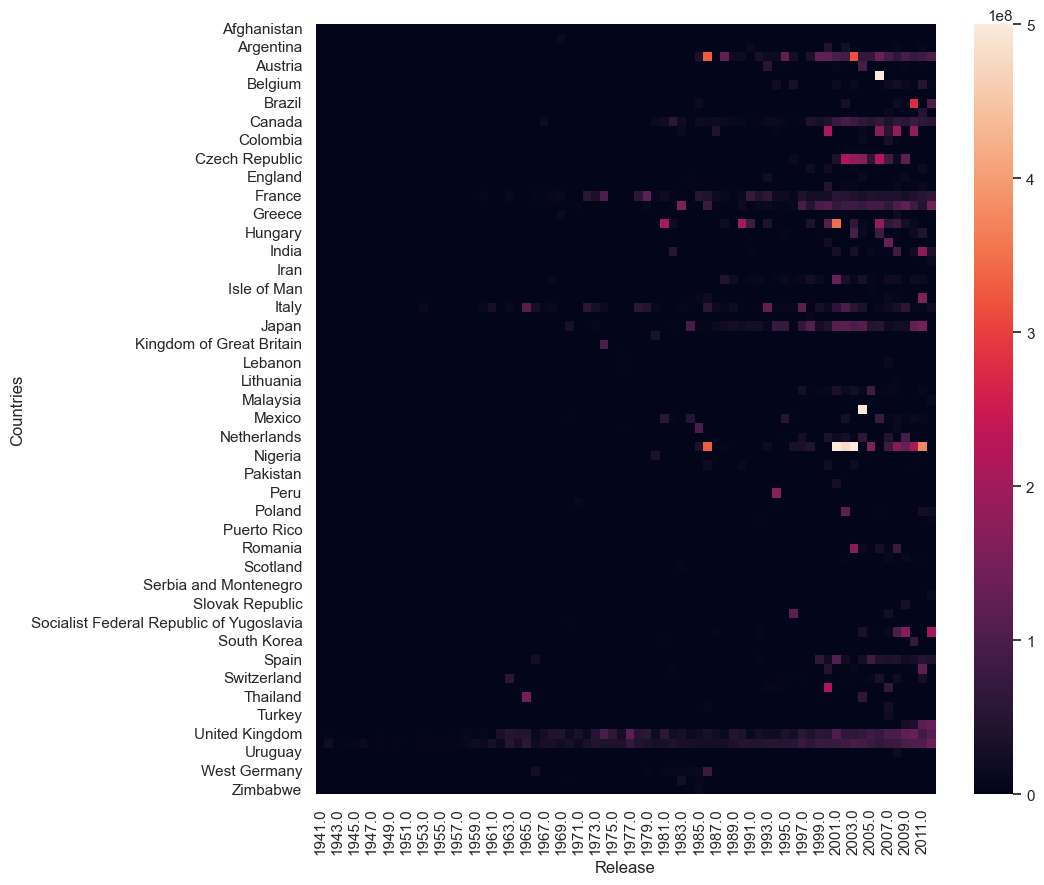

In [107]:
# What are the most common genres for the 5 top producing countries
tmp = processed.explode("Countries")
tmp = tmp[tmp["Release"]>1940].pivot_table(index = 'Countries', columns='Release', values='BoxRevenue', aggfunc='mean', fill_value=0)
sns.heatmap(tmp, vmax=5e8)


39.96051332675222 36.191520467836256


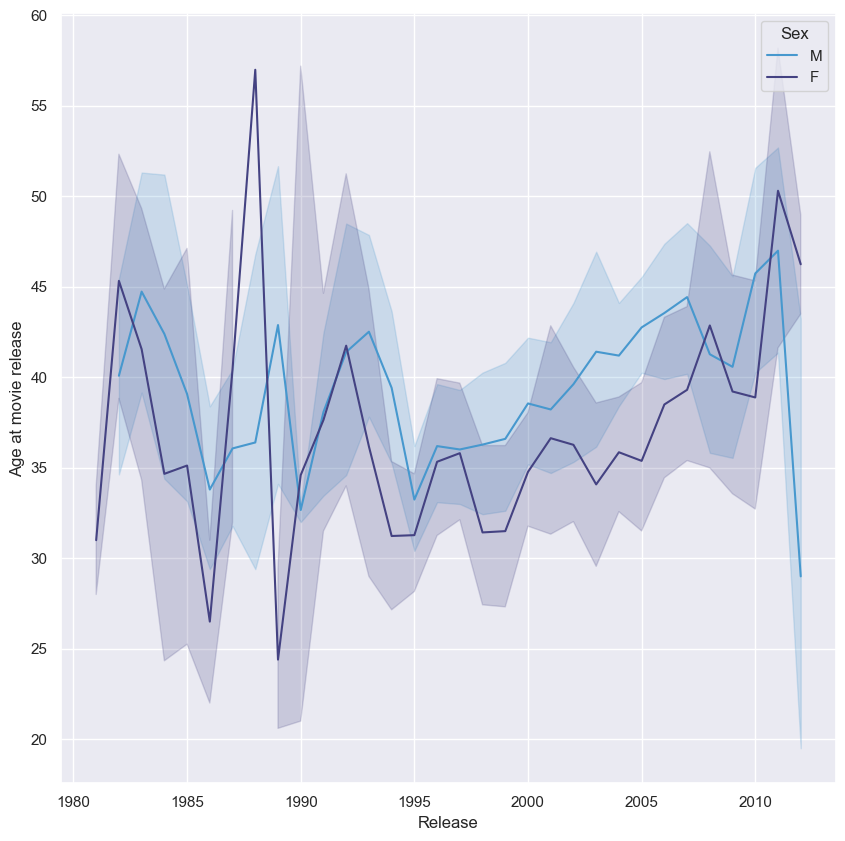

In [108]:
tmp = charac_group.dropna(subset="Release")
# We take 1980 as before there are very few porno movies
tmp = tmp[tmp["Release"]>1980]
tmp = tmp[tmp["Genres"].apply(lambda x: any(e.lower() in lgbt for e in x))]
sns.lineplot(data=tmp, x = "Release", y="Age at movie release", hue="Sex")
print(tmp[tmp["Sex"]=="M"]["Age at movie release"].mean(), tmp[tmp["Sex"]=="F"]["Age at movie release"].mean())